# [Trilemma Foundation](https://www.trilemma.foundation/) x [Strategy](https://www.strategy.com/) Stacking Sats Tournament

**Hosted on [Hypertrial.ai](https://www.hypertrial.ai/stacking-sats)**

### Education Notebook

---
In essence, only the data analysis part of this notebook is relevant, despite not helpful and organized. Apologies to anyone who reads this. I might clean this up in the future.

# Prelude - Do Not Change → You Will Be Disqualified 🚫

In [1]:
# ═══════════════════════════════════════════════════════════════════════════════
#                                     IMPORTS
# ═══════════════════════════════════════════════════════════════════════════════

import numpy as np
import pandas as pd
import polars as pl
import scipy
import statsmodels.api as sm
import sklearn
import networkx as nx
import pgmpy as pg
import pymc as pm
from prophet import Prophet
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from io import BytesIO
import pyarrow

# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

# ═══════════════════════════════════════════════════════════════════════════════
#                                  CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════

# Backtest parameters
BACKTEST_START = '2016-01-01'
BACKTEST_END = '2025-06-01'
INVESTMENT_WINDOW = 12  # months
PURCHASE_FREQ = 'Daily'  # 'Daily', 'Weekly', or 'Monthly'
MIN_WEIGHT = 1e-5

PURCHASE_FREQ_TO_OFFSET = {
    'Daily': '1D',
    'Weekly': '7D',
    'Monthly': '1M',
}

# ═══════════════════════════════════════════════════════════════════════════════
#                                 DATA FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def load_data():
    """Load crypto data directly from GitHub parquet file."""
    url = "https://raw.githubusercontent.com/TrilemmaFoundation/stacking-sats-tournament-mstr-2025/main/data/stacking_sats_data.parquet"
    
    response = requests.get(url)
    response.raise_for_status()
    
    # Read parquet data from bytes
    df = pd.read_parquet(BytesIO(response.content))
    
    # Ensure proper datetime index
    if df.index.name != 'time' and 'time' in df.columns:
        df.set_index('time', inplace=True)
    
    # Clean and sort data
    df.index = pd.to_datetime(df.index).normalize()
    df.index = df.index.tz_localize(None) if df.index.tz is not None else df.index
    df = df.loc[~df.index.duplicated(keep='last')]
    df = df.sort_index()
    
    return df

# ═══════════════════════════════════════════════════════════════════════════════
#                              COMPUTATION FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def _make_window_label(window_start: pd.Timestamp, window_end: pd.Timestamp) -> str:
    """Format human-readable rolling window label as 'YYYY-MM-DD → YYYY-MM-DD'."""
    start_str = pd.to_datetime(window_start).strftime("%Y-%m-%d")
    end_str = pd.to_datetime(window_end).strftime("%Y-%m-%d")
    return f"{start_str} → {end_str}"


def compute_cycle_spd(dataframe: pd.DataFrame, strategy_function) -> pd.DataFrame:
    """
    Compute sats-per-dollar (SPD) statistics over rolling windows.
    
    Uses full-history features with no look-ahead bias. Returns DataFrame with
    SPD statistics and percentiles for uniform vs dynamic strategies.
    """
    # Precompute full-history features & restrict to backtest period
    full_feat = construct_features(dataframe).loc[BACKTEST_START:BACKTEST_END]
    
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step_freq = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    
    results = []
    for window_start in pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step_freq
    ):
        window_end = window_start + window_offset
        feat_slice = full_feat.loc[window_start:window_end]
        price_slice = dataframe["PriceUSD_coinmetrics"].loc[window_start:window_end]
        
        if price_slice.empty:
            continue
            
        label = _make_window_label(window_start, window_end)
        inv_price = (1.0 / price_slice) * 1e8  # sats per dollar
        
        # Compute weights and SPD metrics
        weight_slice = strategy_function(feat_slice)
        uniform_spd = inv_price.mean()
        dynamic_spd = (weight_slice * inv_price).sum()
        
        # Percentile calculations
        min_spd = inv_price.min()
        max_spd = inv_price.max()
        span = max_spd - min_spd
        
        uniform_pct = (uniform_spd - min_spd) / span * 100
        dynamic_pct = (dynamic_spd - min_spd) / span * 100
        
        results.append({
            "window": label,
            "min_sats_per_dollar": min_spd,
            "max_sats_per_dollar": max_spd,
            "uniform_sats_per_dollar": uniform_spd,
            "dynamic_sats_per_dollar": dynamic_spd,
            "uniform_percentile": uniform_pct,
            "dynamic_percentile": dynamic_pct,
            "excess_percentile": dynamic_pct - uniform_pct,
        })
    
    return pd.DataFrame(results).set_index("window")


def backtest_dynamic_dca(
    dataframe: pd.DataFrame,
    strategy_function,
    *,
    strategy_label: str = "strategy"
) -> pd.DataFrame:
    """
    Run rolling-window SPD backtest and print aggregated performance metrics.
    
    Includes standard statistics and exponentially-decayed averages with
    recent windows weighted more heavily.
    """
    spd_table = compute_cycle_spd(dataframe, strategy_function)
    dynamic_spd = spd_table["dynamic_sats_per_dollar"]
    dynamic_pct = spd_table["dynamic_percentile"]
    
    # Print standard aggregated metrics
    print(f"\nAggregated Metrics for {strategy_label}:")
    print("Dynamic Sats-per-Dollar:")
    for stat in ("min", "max", "mean", "median"):
        val = getattr(dynamic_spd, stat)()
        print(f"  {stat}: {val:.2f}")
    
    print("\nDynamic SPD Percentiles:")
    for stat in ("min", "max", "mean", "median"):
        val = getattr(dynamic_pct, stat)()
        print(f"  {stat}: {val:.2f}%")
    
    # Exponential decay weighting (recent windows weighted more heavily)
    decay_rate = 0.9
    N = len(dynamic_spd)
    raw_weights = np.array([decay_rate ** (N - 1 - i) for i in range(N)])
    exp_weights = raw_weights / raw_weights.sum()
    
    exp_avg_spd = (dynamic_spd.values * exp_weights).sum()
    exp_avg_pct = (dynamic_pct.values * exp_weights).sum()
    
    print(f"\nExponential-Decay Average SPD: {exp_avg_spd:.2f}")
    print(f"Exponential-Decay Average SPD Percentile: {exp_avg_pct:.2f}%")
    
    return spd_table, exp_avg_pct

# ═══════════════════════════════════════════════════════════════════════════════
#                              VALIDATION FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def check_strategy_submission_ready(dataframe: pd.DataFrame, strategy_function) -> None:
    """
    Comprehensive validation that strategy function:
    1. Uses no future data (forward-leakage test)
    2. Produces valid weights (≥ MIN_WEIGHT, sum to 1.0)
    3. Outperforms uniform DCA in ≥50% of rolling windows
    """
    passed = True
    
    # Forward-leakage test
    backtest_df = dataframe.loc[BACKTEST_START:BACKTEST_END]
    full_weights = strategy_function(dataframe).reindex(backtest_df.index).fillna(0.0)
    
    step_dates = max(len(backtest_df) // 50, 1)
    probe_dates = backtest_df.index[::step_dates]
    
    for probe in probe_dates:
        masked = dataframe.copy()
        masked.loc[masked.index > probe, :] = np.nan
        
        masked_wt = strategy_function(masked).reindex(full_weights.index).fillna(0.0)
        
        if not np.isclose(masked_wt.loc[probe], full_weights.loc[probe], 
                         rtol=1e-9, atol=1e-12):
            delta = abs(masked_wt.loc[probe] - full_weights.loc[probe])
            print(f"[{probe.date()}] ❌ Forward-leakage detected (Δ={delta:.2e})")
            passed = False
            break
    
    # Weight validation per rolling window
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step_freq = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    
    for window_start in pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step_freq
    ):
        window_end = window_start + window_offset
        label = _make_window_label(window_start, window_end)
        w_slice = strategy_function(dataframe.loc[window_start:window_end])
        
        if (w_slice <= 0).any():
            print(f"[{label}] ❌ Non-positive weights detected.")
            passed = False
        
        if (w_slice < MIN_WEIGHT).any():
            print(f"[{label}] ❌ Weight below MIN_WEIGHT = {MIN_WEIGHT}.")
            passed = False
        
        total = w_slice.sum()
        if not np.isclose(total, 1.0, rtol=1e-5, atol=1e-8):
            print(f"[{label}] ❌ Sum-to-1 check failed: {total:.4f}")
            passed = False
    
    # Performance vs uniform DCA
    spd_table = compute_cycle_spd(dataframe, strategy_function)
    
    underperf_records = []
    for label, row in spd_table.iterrows():
        dp, up = row["dynamic_percentile"], row["uniform_percentile"]
        if dp < up:
            underperf_records.append({
                "Window": label,
                "Dynamic Percentile": dp,
                "Uniform Percentile": up,
                "Delta": dp - up
            })
    
    total = len(spd_table)
    failed = len(underperf_records)
    pass_ratio = (total - failed) / total
    
    if underperf_records:
        df_underperf = pd.DataFrame(underperf_records)
        print("\n⚠️ Windows where strategy underperformed Uniform DCA:")
        display(df_underperf)
    
    print(f"\nSummary: Your strategy underperformed uniform DCA in {failed} out of {total} "
          f"windows ({100 * pass_ratio:.2f}% win rate)")
    
    if pass_ratio >= 0.5:
        print("✅ Strategy meets performance requirement (≥ 50% win rate vs. uniform DCA).")
    else:
        print("❌ Strategy failed performance requirement (< 50% win rate vs. uniform DCA).")
        passed = False
    
    # Final verdict
    if passed:
        print("\n✅ Strategy is ready for submission.")
    else:
        print("\n⚠️ Please address the above issues before submitting.")

# ═══════════════════════════════════════════════════════════════════════════════
#                               PLOTTING FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def _get_window_index(timestamp: pd.Timestamp) -> int:
    """Map timestamp to 0-based rolling-window index."""
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    valid_starts = pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step
    )
    idx = valid_starts.get_indexer([timestamp], method='pad')[0]
    return int(idx)


def plot_features(
    df: pd.DataFrame,
    weights: pd.Series | None = None,
    *,
    start_date: str | pd.Timestamp = BACKTEST_START,
    end_date: str | pd.Timestamp = BACKTEST_END,
) -> None:
    """Plot BTC price vs first derived feature within backtest window."""
    df_feat = construct_features(df).loc[start_date:end_date]
    
    if weights is not None:
        weights = weights.loc[df_feat.index]
    
    feature_name = df_feat.columns[1]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f"BTC Price and {feature_name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    
    ax.plot(df_feat.index, df_feat["PriceUSD_coinmetrics"], label="BTC Price", 
            color="black", alpha=0.7)
    ax.plot(df_feat.index, df_feat[feature_name], label=feature_name, 
            color="orange", alpha=0.7)
    
    signal = df_feat["PriceUSD_coinmetrics"] < df_feat[feature_name]
    ax.fill_between(
        df_feat.index, df_feat["PriceUSD_coinmetrics"], df_feat[feature_name],
        where=signal, color="green", alpha=0.1,
    )
    
    if weights is not None:
        ax.scatter(
            df_feat.index[~signal], df_feat.loc[~signal, "PriceUSD_coinmetrics"],
            marker="o", facecolors="none", edgecolors="blue", label="Uniform",
        )
        ax.scatter(
            df_feat.index[signal], df_feat.loc[signal, "PriceUSD_coinmetrics"],
            marker="o", color="red", label="Dynamic",
        )
    
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def plot_final_weights_by_window(
    dataframe: pd.DataFrame,
    strategy_fn,
    *,
    window_stride: int = 1
):
    """Plot strategy weights for each rolling window (subsampled by window_stride)."""
    window_length = pd.DateOffset(months=INVESTMENT_WINDOW)
    step = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    starts = pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_length,
        freq=step
    )
    
    fig, ax = plt.subplots(figsize=(12, 5))
    cmap = plt.get_cmap("tab10")
    
    for idx, ws in enumerate(starts):
        if idx % window_stride != 0:
            continue
        
        we = ws + window_length
        df_win = dataframe.loc[ws:we]
        w_win = strategy_fn(df_win)
        label = f"{ws.date()} → {we.date()}"
        color = cmap(idx % 10)
        
        ax.plot(w_win.index, w_win.values, label=label, color=color)
        ax.hlines(1.0/len(w_win), w_win.index[0], w_win.index[-1],
                  color=color, linestyle='--', alpha=0.5)
    
    ax.axhline(MIN_WEIGHT, color='black', linestyle='--', 
               label=f"MIN_WEIGHT={MIN_WEIGHT}")
    ax.set_title("Weights by Rolling Window")
    ax.set_xlabel("Date")
    ax.set_ylabel("Weight")
    ax.legend(fontsize='small', ncol=2, loc='upper center')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def plot_rolling_window_weight_sums(dataframe: pd.DataFrame, strategy_fn) -> None:
    """Plot sum of weights for each rolling window (should be ~1.0)."""
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    
    starts = pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step
    )
    
    sums = []
    for ws in starts:
        we = ws + window_offset
        df_window = dataframe.loc[ws:we]
        w = strategy_fn(df_window)
        sums.append(w.sum())
    
    plt.figure(figsize=(12, 5))
    # Plot the actual weight sums (should be close to 1.0)
    plt.plot(starts, sums, marker="o", linestyle="-", color="blue", label="Weight Sums")
    plt.axhline(1.0, color="black", linestyle="--", linewidth=2, label="Target = 1.0")
    
    # Set y-axis to focus around 1.0 to better visualize deviations
    min_sum = min(sums)
    max_sum = max(sums)
    margin = max(0.01, (max_sum - min_sum) * 0.1)  # At least 1% margin
    plt.ylim(min_sum - margin, max_sum + margin)
    
    plt.title("Per-Window Strategy Weight Sums (should be 1.0)")
    plt.xlabel("Window Start Date")
    plt.ylabel("Sum of Weights")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print(f"Weight sum statistics:")
    print(f"  Mean: {np.mean(sums):.6f}")
    print(f"  Min:  {min_sum:.6f}")
    print(f"  Max:  {max_sum:.6f}")
    print(f"  Std:  {np.std(sums):.6f}")
    
    plt.tight_layout()
    plt.show()


def plot_spd_comparison(
    spd_results: pd.DataFrame,
    strategy_name: str = "Dynamic",
    *,
    window_stride: int = 1
) -> None:
    """Compare uniform vs dynamic DCA in SPD and percentile space."""
    subs = spd_results.iloc[::window_stride]
    x = np.arange(len(subs))
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_yscale("log")
    
    # Plot SPD lines
    l_max, = ax1.plot(x, subs["max_sats_per_dollar"], "o-", color="green")
    l_dyn, = ax1.plot(x, subs["dynamic_sats_per_dollar"], "o-", color="blue")
    l_uni, = ax1.plot(x, subs["uniform_sats_per_dollar"], "o-", color="orange")
    l_min, = ax1.plot(x, subs["min_sats_per_dollar"], "o-", color="red")
    
    ax1.set_title(f"Uniform vs {strategy_name} DCA (SPD)")
    ax1.set_ylabel("Sats per Dollar (log scale)")
    ax1.set_xlabel("Window")
    ax1.grid(True, linestyle="--", linewidth=0.5)
    ax1.set_xticks(x)
    ax1.set_xticklabels(subs.index, rotation=45, ha="right")
    ax1.legend(
        [l_max, l_dyn, l_uni, l_min],
        ["Max SPD", strategy_name, "Uniform SPD", "Min SPD"],
        loc="upper left",
    )
    
    # Twin axis for percentiles
    ax2 = ax1.twinx()
    bw = 0.4
    ubar = ax2.bar(x - bw/2, subs["uniform_percentile"], width=bw, 
                   alpha=0.3, color='orange')
    dbar = ax2.bar(x + bw/2, subs["dynamic_percentile"], width=bw, 
                   alpha=0.3, color='blue')
    ax2.set_ylabel("SPD Percentile (%)")
    ax2.set_ylim(0, 100)
    ax2.legend([ubar, dbar], ["Uniform %", f"{strategy_name} %"], 
               loc="upper right")
    
    plt.tight_layout()
    plt.show()

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed
/mnt/c/Users/tamng/Quant Prep/stacking_sats_challenge_2025/stacking-sats-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


# Data analysis

Essentially, I would like to compute correlation between features and future gain/loss using decision trees, linear regressions or the like.

In [155]:
import pandas as pd
import numpy as np
#from typing import Dict, Any
#from core.config import BACKTEST_START, BACKTEST_END, MIN_WEIGHT
#from core.strategies import register_strategy

# MA_WINDOWS = [200, 7, 30, 60, 90, 120, 150, 180]    

# Technically cannot add parameters to this function
def construct_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct technical indicators used for the strategy.
    Uses only past data for calculations to avoid look-ahead bias.

    Args:
        df: DataFrame with price data

    Returns:
        DataFrame with added technical indicators
    """

    MA_WINDOWS = [200, 7, 30, 60, 90, 120, 150, 180, int(INVESTMENT_WINDOW * 30 // 2)]    
    
    df = df.copy()

    # Extract relevant features (using only price here)
    # df = df[['PriceUSD', 'CapMVRVCur']]

    # Shift the PriceUSD column by one to use only past data for our calculations
    past_price = df['PriceUSD_coinmetrics'].shift(1)
    for window in MA_WINDOWS:
        # Calculate <window>-day moving average
        df[f'ma{window}'] = past_price.rolling(window=window, min_periods=1).mean()
        # df[f'hma{window}'] = past_price.rolling(window=window, min_periods=1).apply(stats.hmean, raw = True)
        
        # Calculate <window>-day standard deviation
        df[f'std{window}'] = past_price.rolling(window=window, min_periods=1).std()
        
        # Future <window>-day moving average, <window> days from now
        # For training, this will only be used up to today - (rebalance_window + 1), so the model doesn't see tomorrow's price (or even today's)
        df[f'future_ma{window}'] = df[f'ma{window}'].shift(-window)

        # df = df.copy()
            
        #     past_feature = df[feature].shift(1)
        #     df[feature + f'_ma{window}'] = past_feature.rolling(window=window, min_periods=1).mean()
        #     df[feature + f'_std{window}'] = past_feature.rolling(window=window, min_periods=1).std()          
            
    return df

In [156]:
btc_df = load_data()

In [157]:
SUPPLY_METRICS = ['SplyAct10yr_coinmetrics',
       'SplyAct180d_coinmetrics', 'SplyAct1d_coinmetrics',
       'SplyAct1yr_coinmetrics', 'SplyAct2yr_coinmetrics',
       'SplyAct30d_coinmetrics', 'SplyAct3yr_coinmetrics',
       'SplyAct4yr_coinmetrics', 'SplyAct5yr_coinmetrics',
       'SplyAct7d_coinmetrics', 'SplyAct90d_coinmetrics',
       'SplyActEver_coinmetrics', 'SplyActPct1yr_coinmetrics',
       'SplyAdrBal1in100K_coinmetrics', 'SplyAdrBal1in100M_coinmetrics',
       'SplyAdrBal1in10B_coinmetrics', 'SplyAdrBal1in10K_coinmetrics',
       'SplyAdrBal1in10M_coinmetrics', 'SplyAdrBal1in1B_coinmetrics',
       'SplyAdrBal1in1K_coinmetrics', 'SplyAdrBal1in1M_coinmetrics',
       'SplyAdrBalNtv0.001_coinmetrics', 'SplyAdrBalNtv0.01_coinmetrics',
       'SplyAdrBalNtv0.1_coinmetrics', 'SplyAdrBalNtv1_coinmetrics',
       'SplyAdrBalNtv10_coinmetrics', 'SplyAdrBalNtv100_coinmetrics',
       'SplyAdrBalNtv100K_coinmetrics', 'SplyAdrBalNtv10K_coinmetrics',
       'SplyAdrBalNtv1K_coinmetrics', 'SplyAdrBalNtv1M_coinmetrics',
       'SplyAdrBalUSD1_coinmetrics', 'SplyAdrBalUSD10_coinmetrics',
       'SplyAdrBalUSD100_coinmetrics', 'SplyAdrBalUSD100K_coinmetrics',
       'SplyAdrBalUSD10K_coinmetrics', 'SplyAdrBalUSD10M_coinmetrics',
       'SplyAdrBalUSD1K_coinmetrics', 'SplyAdrBalUSD1M_coinmetrics',
       'SplyAdrTop100_coinmetrics', 'SplyAdrTop10Pct_coinmetrics',
       'SplyAdrTop1Pct_coinmetrics', 'SplyCur_coinmetrics',
       'SplyExpFut10yr_coinmetrics', 'SplyFF_coinmetrics',
       'SplyMiner0HopAllNtv_coinmetrics',
       'SplyMiner0HopAllUSD_coinmetrics',
       'SplyMiner1HopAllNtv_coinmetrics',
       'SplyMiner1HopAllUSD_coinmetrics']

In [158]:
def construct_sply_pct(df):
    df = df.copy()
    for feature in SUPPLY_METRICS:
        if feature in ['SplyMiner0HopAllUSD_coinmetrics', 'SplyMiner1HopAllUSD_coinmetrics', 'SplyCur_coinmetrics']:
            continue
        df[feature + f'_pct'] = df[feature]/df['SplyCur_coinmetrics']
    return df

In [159]:
btc_df = construct_sply_pct(btc_df)

## Some decision tree ideas...

In [383]:
from sklearn import tree

def construct_z_features(df, features, window, rebalance_window):
    # feature = [feature for feature in btc_df.columns if 'coinmetrics' in feature]
    # features = [feature for feature in btc_df.columns  if 'Sply' in feature or 'AdrBal' in feature or 'Flow' in feature or feature == 'PriceUSD_coinmetrics']
    # features = ['PriceUSD_coinmetrics', 'AdrBal1in1BCnt_coinmetrics', 'SplyAct180d_coinmetrics', 'FlowOutExNtv_coinmetrics']
    # features = ['PriceUSD_coinmetrics']
    # features = ['PriceUSD_coinmetrics', 'SplyAct2yr_coinmetrics', 'SplyExpFut10yr_coinmetrics', 'SplyAdrBalUSD10_coinmetrics']
    z_features = []
    df_feat = construct_features(btc_df).loc[BACKTEST_START:BACKTEST_END].drop(columns = ['principal_market_usd_coinmetrics'])
    # window = 200
    # rebalance_window = int(INVESTMENT_WINDOW * 30 // 2)
    feasible_df = df_feat[~df_feat[f'future_ma{rebalance_window}'].isna()].loc[: '2025-06-01']
    
    for feature in features:
       # if 'Sply' in feature or 'AdrBal' in feature or 'Flow' in feature or feature == 'PriceUSD_coinmetrics':
       # if 'Sply' in feature or feature == 'PriceUSD_coinmetrics':
    # if feature == 'PriceUSD_coinmetrics':    
        past_feature = feasible_df[feature].shift(1)
        ma_df = past_feature.rolling(window=window, min_periods=1).mean()
        std_df = past_feature.rolling(window=window, min_periods=1).std()
        z_df = (feasible_df[feature] - ma_df)/ std_df
        if z_df.isna().all():
            continue
        feasible_df = pd.concat([feasible_df, z_df.rename(feature + f'_z{window}')], axis=1)
        z_features.append(feature + f'_z{window}')

    feasible_df = feasible_df[z_features + ['PriceUSD_coinmetrics', f'future_ma{rebalance_window}']].copy()
    feasible_df.replace([np.inf, -np.inf], np.nan, inplace=True)    
    feasible_df.dropna(inplace = True, how = 'all', axis = 1)

    # Too many NAs in this column
    #if f'AdrBalNtv100KCnt_coinmetrics_z{rebalance_window}' in feasible_df.columns:
    #    feasible_df.drop(columns = [f'AdrBalNtv100KCnt_coinmetrics_z{rebalance_window}'], inplace = True)
    #   features.remove(f'AdrBalNtv100KCnt_coinmetrics_z{rebalance_window}')

    # feasible_df.dropna(inplace=True, how = 'any', axis = 0)
    return feasible_df, z_features

In [402]:
from sklearn import model_selection
# from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import plot_tree 
from sklearn.tree import export_text
import matplotlib.pyplot as plt

def decision_tree(df, features, weight = {-1:1, 1:10}, depth = 2, window = 200, rebalance_window = int(INVESTMENT_WINDOW * 30 // 2)):
    feasible_df, z_features = construct_z_features(df, features, window = window, rebalance_window = rebalance_window)
    X, y = pd.concat([feasible_df[z_features], btc_df.loc[feasible_df.index, 'value_classification_feargreed'].map({'None': np.nan, 'Fear': -1, 'Greed': + 1})], axis = 1), (feasible_df[f'future_ma{rebalance_window}']- feasible_df['PriceUSD_coinmetrics']).apply(np.sign)
    # X, y = feasible_df[z_features], ((feasible_df[f'future_ma{rebalance_window}']- feasible_df['PriceUSD_coinmetrics'])/feasible_df['PriceUSD_coinmetrics']).apply(lambda x: 1 if x >= 0 else -1)
    # Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size = 0.1)
    end_date = X.index[-1]
    start_date = pd.to_datetime(end_date) - 16 * pd.DateOffset(days=rebalance_window)
    prec = 0
    recall = 0
    total_pred = 0
    total_true = 0
    for test_date in pd.date_range(start = start_date, end = pd.to_datetime(end_date)):
        if test_date not in X.index:
            continue
        Xtrain = X.loc[(X.index <= test_date - pd.DateOffset(days=rebalance_window + 1)) & (X.index > test_date - 8 * pd.DateOffset(days=rebalance_window))] 
        ytrain = y.loc[(y.index <= test_date - pd.DateOffset(days=rebalance_window + 1)) & (y.index > test_date - 8  * pd.DateOffset(days=rebalance_window))]
        Xtest, ytest = X.loc[[test_date]], y.loc[[test_date]]
        
        #if Xtrain.isna().any().any():
        #    continue
        
        clf = tree.DecisionTreeClassifier(class_weight = weight, max_depth = depth, min_samples_leaf = 0.05)
        # clf = tree.DecisionTreeClassifier(max_depth = 2)
        
        clf.fit(Xtrain, ytrain)
        
        # if test_date == end_date or test_date in [start_date + n * pd.DateOffset(days=rebalance_window) for n in range(13)]:
        #     tree_rules = export_text(clf, feature_names=Xtrain.columns)
        #     print(test_date, tree_rules)
            
            # plt.figure(figsize=(20, 10))
            # plot_tree(
            # clf,
            # feature_names=Xtrain.columns,
            # filled=True,
            # rounded=True,
            # proportion=True,  
            # fontsize=10
            # )
            # plt.show()
            
            
        if ytest.iloc[0] == 1:
            total_true += 1
            recall = (recall * (total_true - 1) + float(clf.predict(Xtest)[0] == 1)) / total_true
        if clf.predict(Xtest)[0] == 1:
            total_pred += 1
            prec = (prec * (total_pred - 1) + float(1 == ytest.iloc[0])) / total_pred
        # print(prec, recall)
        # total += 1
        # rate = (rate * (total - 1) + float((clf.predict(Xtest) == ytest).iloc[0]))/total
    print(feature, prec, recall, 2 * prec * recall/(prec + recall))
    # return 2 * prec * recall/(prec + recall)

In [400]:
# decision_tree(btc_df, weight = {1: 3, -1:1}, depth = None, features = [feature for feature in btc_df.columns if ('coinmetrics' in feature or 'fred' in feature) and (feature != 'principal_market_usd_coinmetrics')], window = 200, rebalance_window = 180)

In [404]:
# for feature in btc_df.columns:
#     if 'Sply' in feature:
#         decision_tree(btc_df, weight = {-1:1, 1:3}, depth = None, features = [feature, 'PriceUSD_coinmetrics'], window = 200, rebalance_window = 180)

In [1]:
# decision_tree(btc_df, weight = {-1:1, 1:3}, depth = 3, features = ['PriceUSD_coinmetrics', 'SplyAdrBalNtv10K_coinmetrics'], rebalance_window = 90, window = 100)

In [2]:
# decision_tree(btc_df, weight = {-1:1, 1:3}, depth = 3, features = ['PriceUSD_coinmetrics'] + [feature for feature in btc_df.columns if 'SplyAct' in feature or 'SplyAdrBal' in feature], rebalance_window = 90, window = 100)

In [3]:
# decision_tree(btc_df, weight = {-1:1, 1:5}, depth = 5, features = ['PriceUSD_coinmetrics', 'VelCur1yr_coinmetrics', 'HashRate30d_coinmetrics', 'NVTAdj90_coinmetrics', 'SplyAct90d_coinmetrics', 'VtyDayRet30d_coinmetrics', 'ROI30d_coinmetrics', 'VtyDayRet180d_coinmetrics' ], rebalance_window = 90, window = 100)

In [4]:
# # decision_tree(btc_df, weight = {1:2, -1:1}, depth = None, features = ['PriceUSD_coinmetrics', 
#                                                                    #'SplyActPct1yr_coinmetrics', 
#                                                                    'SplyAct1yr_coinmetrics', 
#                                                                    'SplyExpFut10yr_coinmetrics', 
#                                                                    #'SplyAdrTop10Pct_coinmetrics', 
#                                                                    #'SplyAdrBal1in10K_coinmetrics',
#                                                                    'SplyAdrTop1Pct_coinmetrics_pct'
#                                                                   ], rebalance_window = 180)

In [5]:
# decision_tree(btc_df, weight = {-1:1, 1:3}, depth = 6, features = ['PriceUSD_coinmetrics', 'SplyActPct1yr_coinmetrics', 'SplyAct2yr_coinmetrics', 'SplyExpFut10yr_coinmetrics', 'SplyAdrBalUSD10_coinmetrics'])

Some of the tree rules out performs a naive guess in terms of accuracy

Next, try implementing a linear tree using sklearn 

In [6]:
# def decision_tree(df, features, weight = {-1:1, 1:10}, depth = 2):
#     feasible_df, z_features = construct_z_features(df, features)
#     X, y = feasible_df[z_features], (feasible_df[f'future_ma{rebalance_window}']- feasible_df['PriceUSD_coinmetrics']).apply(np.sign)
#     # Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size = 0.1)
#     end_date = X.index[-1]
#     start_date = pd.to_datetime(end_date) - 12 * pd.DateOffset(days=rebalance_window)
#     prec = 0
#     recall = 0
#     total_pred = 0
#     total_true = 0
#     for test_date in pd.date_range(start = start_date, end = pd.to_datetime(end_date)):
#         if test_date not in X.index:
#             continue
#         Xtrain = X.loc[(X.index <= test_date - pd.DateOffset(days=rebalance_window + 1)) & (X.index > test_date - 8 * pd.DateOffset(days=rebalance_window))] 
#         ytrain = y.loc[(y.index <= test_date - pd.DateOffset(days=rebalance_window + 1)) & (y.index > test_date - 8 * pd.DateOffset(days=rebalance_window))]
#         Xtest, ytest = X.loc[[test_date]], y.loc[[test_date]]
#         clf = tree.DecisionTreeClassifier(class_weight = weight, max_depth = depth)
#         # clf = tree.DecisionTreeClassifier(max_depth = 2)
#         clf.fit(Xtrain, ytrain)
    
#         if test_date == end_date:
#             tree_rules = export_text(clf, feature_names=list(Xtrain.columns))
#             print(tree_rules)
#             tree.plot_tree(clf, proportion=True)
#             plt.show()
#         if ytest.iloc[0] == 1:
#             total_true += 1
#             recall = (recall * (total_true - 1) + float(clf.predict(Xtest)[0] == 1)) / total_true
#         if clf.predict(Xtest)[0] == 1:
#             total_pred += 1
#             prec = (prec * (total_pred - 1) + float(1 == ytest.iloc[0])) / total_pred
#         # print(prec, recall)
#         # total += 1
#         # rate = (rate * (total - 1) + float((clf.predict(Xtest) == ytest).iloc[0]))/total
#     print(prec, recall)

In [8]:
# # from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LinearRegression
# # from sklearn.tree import DecisionTreeClassifier
# from scipy.stats import pearsonr

# def linear_tree(df, features, weight = {-1:1, 1:5}, depth = 5, window = 200, rebalance_window = int(INVESTMENT_WINDOW * 30 // 2)):
    
#     feasible_df, z_features = construct_z_features(btc_df,  features = features, window = window, rebalance_window = rebalance_window)
#     X, y = feasible_df[z_features], (feasible_df[f'future_ma{rebalance_window}']- feasible_df['PriceUSD_coinmetrics'])/feasible_df['PriceUSD_coinmetrics']
    
#     end_date = X.index[-1]
#     start_date = pd.to_datetime(end_date) - 12 * pd.DateOffset(days=rebalance_window)
#     ypred = pd.Series(index = pd.date_range(start = start_date, end = pd.to_datetime(end_date)))
    
#     for test_date in pd.date_range(start = start_date, end = pd.to_datetime(end_date)):
#         # Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size = 0.1)
#         # test_date = start_date + pd.DateOffset(days = 3 * 365 + 180)
#         # test_date = end_date
#         # test_date = start_date
        
#         Xtrain = X.loc[(X.index <= test_date - pd.DateOffset(days=rebalance_window + 1)) & (X.index > test_date - 8 * pd.DateOffset(days=rebalance_window))] 
#         ytrain = y.loc[(y.index <= test_date - pd.DateOffset(days=rebalance_window + 1)) & (y.index > test_date - 8 * pd.DateOffset(days=rebalance_window))]
#         Xtest, ytest = X.loc[[test_date]], y.loc[[test_date]]
        
#         clf = tree.DecisionTreeClassifier(max_depth = depth, class_weight = weight)
#         clf.fit(Xtrain, ytrain.apply(np.sign))

#         # ypred[test_date] = clf.predict_proba(Xtest)
        
#         leaf_ids = clf.predict(Xtrain)
#         leaf_models = {}
#         unique_leaves = np.unique(leaf_ids)
    
#         # Fit linear regression at the leaves (in this case cluster leaves by predicted label)
#         for leaf in unique_leaves:
#             idx = (leaf_ids == leaf)
#             # print(f'leaf {leaf} has score {pearsonr(X_leaf.iloc[:, 0], y_leaf)}')
            
#             linreg = LinearRegression()
#             linreg.fit(Xtrain[idx], ytrain[idx])
            
#             leaf_models[leaf] = linreg
    
#         leaf_id_pred = clf.predict(Xtest)[0]
#         ypred[test_date] = leaf_models[leaf_id_pred].predict(Xtest)
        
#     return ypred, y[ypred.index]

In [9]:
# ypred, ytrue = linear_tree(btc_df, weight = {-1:1, 1:3}, depth = 5, features = ['PriceUSD_coinmetrics', 'SplyActPct1yr_coinmetrics', 'SplyAct2yr_coinmetrics', 'SplyExpFut10yr_coinmetrics', 'SplyAdrBalUSD10_coinmetrics'])

In [10]:
# ypred, ytrue = linear_tree(btc_df, features = ['PriceUSD_coinmetrics'], depth = 2, weight = {-1:1, 1:10})

Trying some neural network but taking too long, doesn't seem very attractive atm

In [7]:
# from sklearn.neural_network import MLPRegressor

# def neural_net(df, features, sizes):
#     feasible_df, z_features = construct_z_features(df, features)
#     X, y = feasible_df[z_features], (feasible_df[f'future_ma{rebalance_window}']- feasible_df['PriceUSD_coinmetrics'])/feasible_df['PriceUSD_coinmetrics']
#     # Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size = 0.1)
#     end_date = X.index[-1]
#     start_date = pd.to_datetime(end_date) - 12 * pd.DateOffset(days=rebalance_window)
#     prec = 0
#     recall = 0
#     total_pred = 0
#     total_true = 0

#     ypred = pd.Series(index = pd.date_range(start = start_date, end = pd.to_datetime(end_date)))
#     for test_date in pd.date_range(start = start_date, end = pd.to_datetime(end_date)):
#         if test_date not in X.index:
#             continue
#         Xtrain = X.loc[(X.index <= test_date - pd.DateOffset(days=rebalance_window + 1)) & (X.index > test_date - 8 * pd.DateOffset(days=rebalance_window))] 
#         ytrain = y.loc[(y.index <= test_date - pd.DateOffset(days=rebalance_window + 1)) & (y.index > test_date - 8 * pd.DateOffset(days=rebalance_window))]
#         Xtest, ytest = X.loc[[test_date]], y.loc[[test_date]]
        
#         model = MLPRegressor(hidden_layer_sizes= sizes, activation='relu', max_iter=500, random_state=42)
#         model.fit(Xtrain, ytrain)
#         ypred.loc[test_date] = model.predict(Xtest)[0]
    
#         # if test_date == end_date:
#         #     tree_rules = export_text(clf, feature_names=list(Xtrain.columns))
#         #     print(tree_rules)
#         #     tree.plot_tree(clf, proportion=True)
#         #     plt.show()
#         if ytest.iloc[0] > 0:
#             total_true += 1
#             recall = (recall * (total_true - 1) + float(ypred.loc[test_date] > 0)) / total_true
#         if ypred.loc[test_date] > 0:
#             total_pred += 1
#             prec = (prec * (total_pred - 1) + float(ytest.iloc[0] > 0)) / total_pred
#         # print(prec, recall)
#         # total += 1
#         # rate = (rate * (total - 1) + float((clf.predict(Xtest) == ytest).iloc[0]))/total
#     print(prec, recall)



In [11]:
# neural_net(btc_df, features = ['PriceUSD_coinmetrics', 'SplyAct2yr_coinmetrics', 'SplyExpFut10yr_coinmetrics', 'SplyAdrBalUSD10_coinmetrics'], sizes = (5, 8, 4, 1))

## Statistical correlation computation. This was more helpful, or at least informative

In [514]:
import warnings
from pandas.errors import PerformanceWarning

warnings.simplefilter(action="ignore", category=PerformanceWarning)

In [687]:
df_feat = construct_features(btc_df).loc[BACKTEST_START:BACKTEST_END].drop(columns = ['principal_market_usd_coinmetrics', 'value_classification_feargreed'])
df_feat = construct_sply_pct(df_feat)
window = 200
rebalance_window = 180
feasible_df = df_feat[~df_feat['future_ma180'].isna()].loc['2016-01-01': '2024-05-31']
# for feature in ['FlowOutExUSD_coinmetrics', 'AdrBal1in10MCnt_coinmetrics', 'AdrBalNtv10Cnt_coinmetrics','AdrBalUSD100Cnt_coinmetrics', 'AdrBalUSD100KCnt_coinmetrics', \
#                 'AdrBalUSD10Cnt_coinmetrics','SplyAct180d_coinmetrics','SplyAct1yr_coinmetrics','SplyActPct1yr_coinmetrics', 'SplyAdrBalNtv100K_coinmetrics']:

for feature in feasible_df.columns:
    past_feature = feasible_df[feature].shift(1)
    feasible_df[feature + f'_ma{window}'] = past_feature.rolling(window=window, min_periods=1).mean()

feasible_df = feasible_df[~feasible_df[feasible_df.columns[0] + f'_ma{window}'].isna()]


for feature in feasible_df.columns:        
    try:
        coeff, pval = scipy.stats.pearsonr((feasible_df[feature] - feasible_df[feature + f'_ma{window}'])/feasible_df[feature + f'_ma{window}'], (feasible_df[f'future_ma{rebalance_window}'] - feasible_df['PriceUSD_coinmetrics'])/feasible_df['PriceUSD_coinmetrics'])
    except:
        continue
    if np.abs(coeff) > 0.4 and pval < 0.05:
        print(feature, f'{coeff}, {pval}')
        print(((feasible_df[feature] - feasible_df[feature + f'_ma{window}'])/feasible_df[feature + f'_ma{window}']).mean())

AdrBal1in10KCnt_coinmetrics 0.45065897156194656, 1.302783151641417e-153
0.004863382153668991
SplyAdrBalNtv10K_coinmetrics -0.41946105702696246, 3.0448825044953303e-131
0.00023690333588799635


/mnt/c/Users/tamng/Quant Prep/stacking_sats_challenge_2025/stacking-sats-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


SplyAdrTop100_coinmetrics -0.42805896786642733, 3.5619225036772803e-137
0.00013757861618908754
EEM_Open_yfinance 0.4456120790130995, 7.838934675290651e-150
0.016427222825748367
EEM_High_yfinance 0.44574011380982886, 6.297450697898413e-150
0.01631409348473753
EEM_Low_yfinance 0.44680144216917467, 1.0217339806388416e-150
0.016607664946553156
EEM_Close_yfinance 0.44662191757921743, 1.3903848096627402e-150
0.016482987226018105
EURUSD=X_Open_yfinance 0.4410248490544595, 1.8812523525505916e-146
-0.00025529674220734654
EURUSD=X_High_yfinance 0.441565336431822, 7.56614666052225e-147
-0.0002985129223905045
EURUSD=X_Low_yfinance 0.4452821294005812, 1.377605618000518e-149
-0.0001967994298894064
EURUSD=X_Close_yfinance 0.44112117618018953, 1.5995565570986583e-146
-0.00025601903400350787
DTWEXBGS_Value_fred -0.4118506157029795, 3.906064054633894e-126
0.002222924462114244
DEXUSEU_Value_fred 0.44494470426826177, 2.450535040301853e-149
-0.0002494741063285494
SplyAdrBalNtv10K_coinmetrics_pct -0.4278704

In [688]:
for feature in feasible_df.columns:
    try:
        coeff, pval = scipy.stats.pearsonr(feasible_df[feature], (feasible_df[f'future_ma{rebalance_window}'] - feasible_df['PriceUSD_coinmetrics'])/feasible_df['PriceUSD_coinmetrics'])
    except:
        continue
    if (np.abs(coeff) > 0.35 and pval < 0.05) or 'fear' in feature:
        print(feature, f'{coeff}, {pval}')
        print((feasible_df[feature]).mean())

AdrBal1in1MCnt_coinmetrics 0.3852302707924109, 2.797259347254316e-109
104185.35535307517
AdrBalNtv100Cnt_coinmetrics 0.35274698366007606, 9.93383288182196e-91
16608.08200455581
AdrBalUSD100KCnt_coinmetrics -0.35193602980876226, 2.711526778796498e-90
210360.74389847054
AdrBalUSD10MCnt_coinmetrics -0.36357239688806975, 1.1264967390790095e-96
3400.00976244712
AdrBalUSD1MCnt_coinmetrics -0.35931378794201135, 2.6197129308145376e-94
37742.947608200455
CapAct1yrUSD_coinmetrics -0.39707079354459257, 1.3818363051558357e-116
139686851368.14618
CapMrktCurUSD_coinmetrics -0.36310970607209414, 2.044562333638476e-96
357082742549.93054
CapMrktFFUSD_coinmetrics -0.37662056634316066, 3.742949390679494e-104
267990038966.19745
CapRealUSD_coinmetrics -0.37188415449775464, 2.127871430808328e-101
204064249526.98132
IssContUSD_coinmetrics -0.4578723220503724, 3.992494002323855e-159
19536438.918591272
IssTotUSD_coinmetrics -0.4578723220503724, 3.992494002323855e-159
19536438.918591272
PriceUSD_coinmetrics -0.

In [689]:
selected_features = ['PriceUSD_coinmetrics','EEM_Open_yfinance', 'SplyAdrBalNtv10K_coinmetrics_pct', 'EURUSD=X_Open_yfinance', 'DEXUSEU_Value_fred'] 
for feature in selected_features:
    print(((feasible_df[feature] - feasible_df[feature + f'_ma{window}'])/feasible_df[feature + f'_ma{window}']).mean())

0.2096844819602605
0.016427222825748367
-0.008229592475636665
-0.00025529674220734654
-0.0002494741063285494


In [691]:
for feature1, feature2 in [(x, y) for x in selected_features for y in selected_features]:
    coeff, pval = scipy.stats.pearsonr((feasible_df[feature1] - feasible_df[feature1 + f'_ma{window}'])/feasible_df[feature1 + f'_ma{window}'], (feasible_df[feature2] - feasible_df[feature2 + f'_ma{window}'])/feasible_df[feature2 + f'_ma{window}'])
    print(feature1, feature2, coeff, pval)

PriceUSD_coinmetrics PriceUSD_coinmetrics 1.0 0.0
PriceUSD_coinmetrics EEM_Open_yfinance 0.5599778600233192 3.149782576524773e-253
PriceUSD_coinmetrics SplyAdrBalNtv10K_coinmetrics_pct -0.08664115220356064 1.5091935803599266e-06
PriceUSD_coinmetrics EURUSD=X_Open_yfinance 0.4497075932199679 6.795232696707421e-153
PriceUSD_coinmetrics DEXUSEU_Value_fred 0.4520930447485373 1.0697230729867957e-154
EEM_Open_yfinance PriceUSD_coinmetrics 0.5599778600233192 3.149782576524773e-253
EEM_Open_yfinance EEM_Open_yfinance 1.0 0.0
EEM_Open_yfinance SplyAdrBalNtv10K_coinmetrics_pct -0.23070735650687235 2.0846598505371245e-38
EEM_Open_yfinance EURUSD=X_Open_yfinance 0.6861663619203172 0.0
EEM_Open_yfinance DEXUSEU_Value_fred 0.6903494095327269 0.0
SplyAdrBalNtv10K_coinmetrics_pct PriceUSD_coinmetrics -0.08664115220356064 1.5091935803599266e-06
SplyAdrBalNtv10K_coinmetrics_pct EEM_Open_yfinance -0.23070735650687235 2.0846598505371245e-38
SplyAdrBalNtv10K_coinmetrics_pct SplyAdrBalNtv10K_coinmetrics_pct

In [681]:
for feature in selected_features:
    print(feature, (feasible_df[feature] / feasible_df[feature + f'_ma{window}'] - 1).mean(), (feasible_df[feature] / feasible_df[feature + f'_ma{window}'] - 1).std())

EEM_Open_yfinance 0.01642722282574837 0.0734927309208447
SplyAdrBalNtv10K_coinmetrics_pct -0.008229592475636665 0.04640596649045501
EURUSD=X_Open_yfinance -0.00025529674220734497 0.03022982928485792
DEXUSEU_Value_fred -0.0002494741063285478 0.030087145648077122


## Some PCA ideas that did not work

In [682]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_feat = construct_features(btc_df).loc[BACKTEST_START:BACKTEST_END].drop(columns = ['principal_market_usd_coinmetrics', 'value_classification_feargreed'])
df_feat = construct_sply_pct(df_feat)
window = 200
rebalance_window = 180
feasible_df = df_feat[~df_feat['future_ma180'].isna()].loc['2024-01-01': '2025-05-01']

for feature in feasible_df.columns:
    past_feature = feasible_df[feature].shift(1)
    feasible_df[feature + f'_ma{window}'] = past_feature.rolling(window=window, min_periods=1).mean()
    # feasible_df = feasible_df[~feasible_df[feature + f'_ma{window}'].isna()]

In [589]:
logdiff_features = []
matched_cols = feasible_df.filter(regex=r'^AdrBal.*Cnt_coinmetrics$').columns.tolist()
for feature in  matched_cols:
    feasible_df[f'{feature}_logdiff'] = feasible_df[feature].apply(np.log) - feasible_df[feature + f'_ma{window}'].apply(np.log)
    logdiff_features.append(f'{feature}_logdiff')

X = feasible_df[logdiff_features].dropna(axis = 0, how = 'all')

X = X.dropna(axis = 1)

# Standardize first
X_scaled = StandardScaler().fit_transform(X)

# PCA
n = 2
pca = PCA(n_components=n)
X_reduced = pca.fit_transform(X_scaled)
pca_features = [f'AdrBalCnt_logdiff_PCA_{j}' for j in range(1, n + 1)]

X_reduced_df = pd.DataFrame(X_reduced, columns=pca_features, index=X.index)
feasible_df = feasible_df.join(X_reduced_df)

In [592]:
feasible_df = feasible_df[~feasible_df['AdrBalCnt_logdiff_PCA_1'].isna()]

In [593]:
feasible_df[pca_features]

,AdrBalCnt_logdiff_PCA_1,AdrBalCnt_logdiff_PCA_2
time,,
2024-01-02,-2.667968,0.116974
2024-01-03,-3.435805,0.565750
2024-01-04,-2.820108,0.239030
2024-01-05,-2.925137,0.208541
2024-01-06,-2.838005,0.103601
...,...,...
2024-12-29,6.638225,5.115953
2024-12-30,6.379427,5.003068
2024-12-31,6.436908,5.005790


## Correlation computation repeated, but for z-score instead of percentage change

In [683]:
feasible_df, z_features = construct_z_features(feasible_df, features = [feature for feature in btc_df.columns if ('coinmetrics' in feature) and (feature != 'principal_market_usd_coinmetrics')], window = window, rebalance_window = rebalance_window)

In [684]:
missing_counts = feasible_df.isnull().sum()

columns_to_drop = missing_counts[missing_counts > 2].index
feasible_df = feasible_df.drop(columns=columns_to_drop)
feasible_df = feasible_df.dropna(axis = 0, how = 'any').loc['2016-01-01':'2024-05-31']

In [685]:
for feature in z_features:
    if feature not in feasible_df.columns:
        continue
    coeff, pval = scipy.stats.pearsonr(feasible_df[feature], feasible_df[f'future_ma{rebalance_window}'].apply(np.log) - feasible_df['PriceUSD_coinmetrics'].apply(np.log))
    if (np.abs(coeff) > 0.2 and pval < 0.05) or 'Price' in feature:
        lr
        print(feature, f'{coeff}, {pval}')
        print(feasible_df[feature].mean())

AdrBalNtv100Cnt_coinmetrics_z200 0.24091742901901808, 8.187955749850754e-42
-0.1846175993537024
AdrBalUSD100Cnt_coinmetrics_z200 0.20901957136035312, 1.1341701704975814e-31
0.7850759486426943
AdrBalUSD100KCnt_coinmetrics_z200 0.23169737022809828, 1.0156161715811628e-38
0.670336837333596
AdrBalUSD10KCnt_coinmetrics_z200 0.22715890455587268, 3.0244488598735895e-37
0.6983973398011004
AdrBalUSD1KCnt_coinmetrics_z200 0.2142826584155877, 3.084399624855373e-33
0.7725630003763887
AdrBalUSD1MCnt_coinmetrics_z200 0.2472255487862435, 5.238979536490021e-44
0.6431847859549747
CapMVRVCur_coinmetrics_z200 0.2218778564183804, 1.430642270454731e-35
0.27164591533701443
CapMVRVFF_coinmetrics_z200 0.21939821138378746, 8.455170407168329e-35
0.23609081342185276
CapMrktCurUSD_coinmetrics_z200 0.2089211134802193, 1.2121728006027014e-31
0.6777318182630007
CapMrktFFUSD_coinmetrics_z200 0.212568223895108, 1.0086671291285361e-32
0.6522565367165868
FeeMeanNtv_coinmetrics_z200 0.20942673601540193, 8.611236613141541

In [457]:
(feasible_df[f'future_ma{rebalance_window}'].apply(np.log) - feasible_df['PriceUSD_coinmetrics'].apply(np.log)).mean()

0.17824393512237963

# The rest of the notebook can be ignored
This can be ignored

In [2]:
# Example Ethereum wallet address - replace with real one for actual submissions
#ETH_WALLET_ADDRESS = "0x71C7656EC7ab88b098defB751B7401B5f6d8976F"

#@register_strategy(ETH_WALLET_ADDRESS)

In [3]:
btc_df = load_data()

In [119]:
import pandas as pd
import numpy as np
#from typing import Dict, Any
#from core.config import BACKTEST_START, BACKTEST_END, MIN_WEIGHT
#from core.strategies import register_strategy

# MA_WINDOWS = [200, 7, 30, 60, 90, 120, 150, 180]    

# Technically cannot add parameters to this function
def construct_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct technical indicators used for the strategy.
    Uses only past data for calculations to avoid look-ahead bias.

    Args:
        df: DataFrame with price data

    Returns:
        DataFrame with added technical indicators
    """

    MA_WINDOWS = [200, 7, 30, 60, 90, 120, 150, 180, int(INVESTMENT_WINDOW * 30 // 2)]    
    
    df = df.copy()

    features = ['PriceUSD_coinmetrics', 'SplyAct2yr_coinmetrics', 'SplyExpFut10yr_coinmetrics', 'SplyAdrBalUSD10_coinmetrics'] 
    df = df[features]

    # Shift the PriceUSD column by one to use only past data for our calculations
    past_price = df['PriceUSD_coinmetrics'].shift(1)
    for window in MA_WINDOWS:
        # Calculate <window>-day moving average
        df[f'ma{window}'] = past_price.rolling(window=window, min_periods=1).mean()
        # df[f'hma{window}'] = past_price.rolling(window=window, min_periods=1).apply(stats.hmean, raw = True)
        
        # Calculate <window>-day standard deviation
        #df[f'std{window}'] = past_price.rolling(window=window, min_periods=1).std()

        for feature in features:
           # if 'Sply' in feature or 'AdrBal' in feature or 'Flow' in feature or feature == 'PriceUSD_coinmetrics':
           # if 'Sply' in feature or feature == 'PriceUSD_coinmetrics':
            # if feature == 'PriceUSD_coinmetrics':    
            past_feature = df[feature].shift(1)
            ma_df = past_feature.rolling(window=window, min_periods=1).mean()
            std_df = past_feature.rolling(window=window, min_periods=1).std()
            df[feature + f'_z{window}'] = (past_feature - ma_df)/std_df
            
    return df

In [120]:
def enhanced_moving_avg(df_window: pd.DataFrame, boost_alpha = 1.25, boost_beta = 0.75, rebalance_window = int(INVESTMENT_WINDOW * 30 // 2), window = 200) -> pd.Series:
    """
    Given a 12-month slice, compute portfolio weights that sum to 1.
    Whenever a day’s weight is ‘boosted’, redistribute the excess uniformly
    over the last half of the window (i.e. the final ~6 months).
    """
    # 1. Build feature DataFrame and index info
    features = construct_features(df_window)
    dates = features.index
    total_days = len(features)

    
    # 2. Prepare output Series
    weights = pd.Series(index=dates, dtype=float)

    # 3. Strategy parameters
    #    PURCHASE_FREQ is one of 'Daily', 'Weekly', or 'Monthly'
    # half of the window in rows = half of total_days
    rebalance_window = max(total_days // 2, 1)
    # boost_alpha      = 1.5

    # 4. Initialize equal weights
    base_weight  = 1.0 / total_days
    temp_weights = np.full(total_days, base_weight)

    # 5. Extract numpy arrays for speed
    feature_array = {feature: features[feature].values for feature in ["PriceUSD_coinmetrics_z200", "SplyAct2yr_coinmetrics_z200", "SplyExpFut10yr_coinmetrics_z200", "SplyAdrBalUSD10_coinmetrics_z200"]}
    
    #['AdrBal1in10MCnt_coinmetrics', 'SplyAct180d_coinmetrics', 'FlowOutExNtv_coinmetrics']

    # 6. Loop through each day
    for day_idx in range(total_days):
        price_z200  = feature_array["PriceUSD_coinmetrics_z200"][day_idx]
        splyact2yr_z200 = feature_array["SplyAct2yr_coinmetrics_z200"][day_idx]
        splyexpfut10yr_z200 = feature_array["SplyExpFut10yr_coinmetrics_z200"][day_idx]
        splyadrbalusd10_z200 = feature_array["SplyAdrBalUSD10_coinmetrics_z200"][day_idx]
        

        # skip if no valid signal
        if pd.isna(price_z200):
            continue
        if price_z200 >= 0:
            continue
        
        boosted_weight = temp_weights[day_idx] * (1 - boost_alpha * price_z200)
        
        excess = boosted_weight - temp_weights[day_idx]

        # redistribute excess over the last half of the window
        start_redistribution = max(total_days - rebalance_window, day_idx + 1)
        redistribution_indices = np.arange(start_redistribution, total_days)
        if redistribution_indices.size == 0:
            continue  # nothing to drain from

        per_day_reduction = excess / redistribution_indices.size

        # apply only if no one falls below MIN_WEIGHT
        if np.all(temp_weights[redistribution_indices] - per_day_reduction >= MIN_WEIGHT):
            temp_weights[day_idx] = boosted_weight
            temp_weights[redistribution_indices] -= per_day_reduction
        # else: skip this boost but continue looping

    # 7. Assign back into a pandas Series and return
    weights.loc[dates] = temp_weights
    return weights

In [122]:
def moving_avg(df_window: pd.DataFrame, boost_alpha = 1.25, rebalance_window = int(INVESTMENT_WINDOW * 30 // 2), window = 500) -> pd.Series:
    """
    Given a 12-month slice, compute portfolio weights that sum to 1.
    Whenever a day’s weight is ‘boosted’, redistribute the excess uniformly
    over the last half of the window (i.e. the final ~6 months).
    """
    # 1. Build feature DataFrame and index info
    features = construct_features(df_window)
    dates = features.index
    total_days = len(features)

    # 2. Prepare output Series
    weights = pd.Series(index=dates, dtype=float)

    # 3. Strategy parameters
    #    PURCHASE_FREQ is one of 'Daily', 'Weekly', or 'Monthly'
    # half of the window in rows = half of total_days
    rebalance_window = max(total_days // 2, 1)
    # boost_alpha      = 1.25

    # 4. Initialize equal weights
    base_weight  = 1.0 / total_days
    temp_weights = np.full(total_days, base_weight)

    # 5. Extract numpy arrays for speed
    price_array  = features["PriceUSD_coinmetrics"].values
    ma200_array  = features["ma200"].values
    std200_array = features["std200"].values

    # 6. Loop through each day
    for day_idx in range(total_days):
        price = price_array[day_idx]
        ma200 = ma200_array[day_idx]
        std200 = std200_array[day_idx]

        # skip if no valid signal
        if pd.isna(ma200) or pd.isna(std200) or std200 == 0 or price >= ma200:
            continue

        # compute how far below MA200
        z_score = (ma200 - price) / std200

        # boost this day’s weight
        boosted_weight = temp_weights[day_idx] * (1 + boost_alpha * z_score)
        excess = boosted_weight - temp_weights[day_idx]

        # redistribute excess over the last half of the window
        start_redistribution = max(total_days - rebalance_window, day_idx + 1)
        redistribution_indices = np.arange(start_redistribution, total_days)
        if redistribution_indices.size == 0:
            continue  # nothing to drain from

        per_day_reduction = excess / redistribution_indices.size

        # apply only if no one falls below MIN_WEIGHT
        if np.all(temp_weights[redistribution_indices] - per_day_reduction >= MIN_WEIGHT):
            temp_weights[day_idx] = boosted_weight
            temp_weights[redistribution_indices] -= per_day_reduction
        # else: skip this boost but continue looping

    # 7. Assign back into a pandas Series and return
    weights.loc[dates] = temp_weights
    return weights

In [ ]:
df, pct = backtest_dynamic_dca_tuning(dataframe = btc_df, strategy_function = lambda df: moving_avg(df, boost_alpha =  1.75), strategy_label = "moving_avg", backtest_start = '2021-11-01', backtest_end = '2022-11-01')

This seems to suggest that moving average signals are already absorbed by the MVRV indicator

In [ ]:
# def mvrv_moving_avg_objective(trial):
#     # Define search space (box constraints)
#     alpha = trial.suggest_float("alpha", 0, 2)
#     beta = trial.suggest_float("beta", 20, 30)

#     # Run your complex computation (e.g., simulation, backtest, model)
#     df_res = compute_cycle_spd(df, lambda df: mvrv_moving_avg(df, alpha = alpha, beta = beta, window = 200, rebalance_window = int(365 * CYCLE_YEARS * 1/2)))
#     score = df_res.loc[:, 'excess_pct'].mean() - df_res.loc[:, 'excess_pct'].std()

#     return score

# study = optuna.create_study(direction="maximize")
# study.optimize(mvrv_moving_avg_objective, n_trials=200)

# print("Best parameters:", study.best_params)
# print("Best objective value:", study.best_value)

In [ ]:
# def mvrv_moving_avg_objective(trial):
#     # Define search space (box constraints)
#     alpha = trial.suggest_float("alpha", 0, 0)
#     beta = trial.suggest_float("beta", 0, 35)

#     # Run your complex computation (e.g., simulation, backtest, model)
#     df_res = compute_cycle_spd(df_feat, lambda df: mvrv_moving_avg(df, alpha = alpha, beta = beta, window = 200, rebalance_window = 360, logarithm = True))
#     score = df_res.loc[:, 'excess_pct'].mean()

#     return score  # You are minimizing this

# study = optuna.create_study(direction="maximize")
# study.optimize(mvrv_moving_avg_objective, n_trials=100)

# print("Best parameters:", study.best_params)
# print("Best objective value:", study.best_value)

## Final compute weights method
This can also be ignored

In [125]:
def compute_weights(df_window: pd.DataFrame) -> pd.Series:
    return enhanced_moving_avg(df_window) 

## Runner - Do Not Change → You Will Be Disqualified 🚫

Starting Bitcoin DCA Strategy Analysis...
Loading data...
Data loaded: 3440 records from 2016-01-01 to 2025-06-01

1. Plotting features...


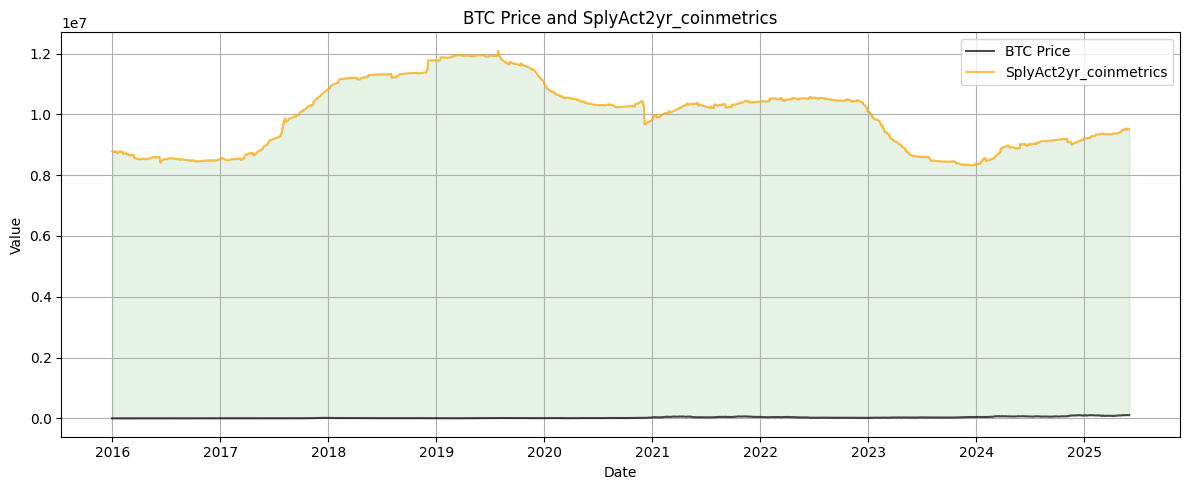


2. Plotting final weights by window...


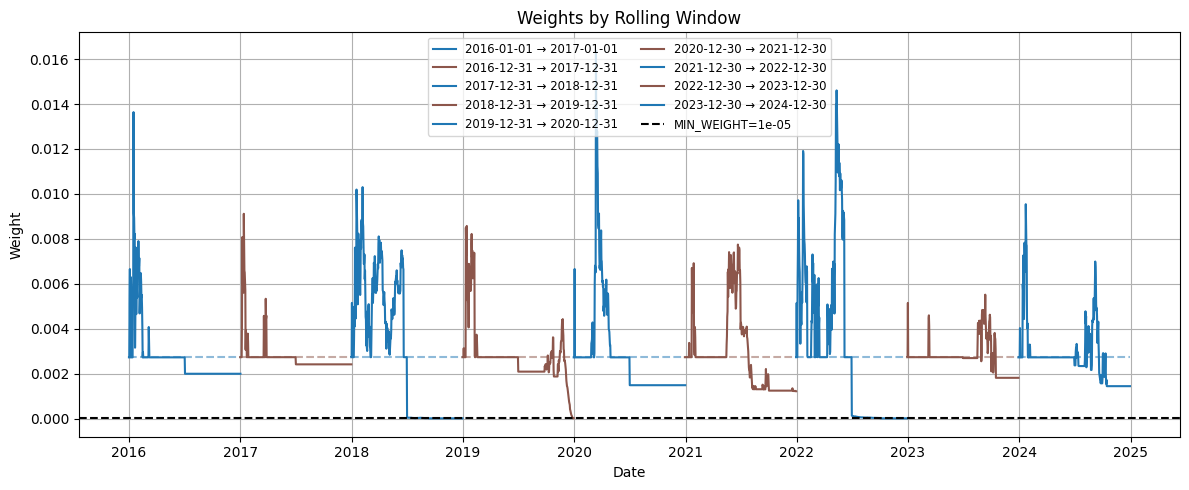


3. Checking rolling window weight sums...
Weight sum statistics:
  Mean: 1.000000
  Min:  1.000000
  Max:  1.000000
  Std:  0.000000


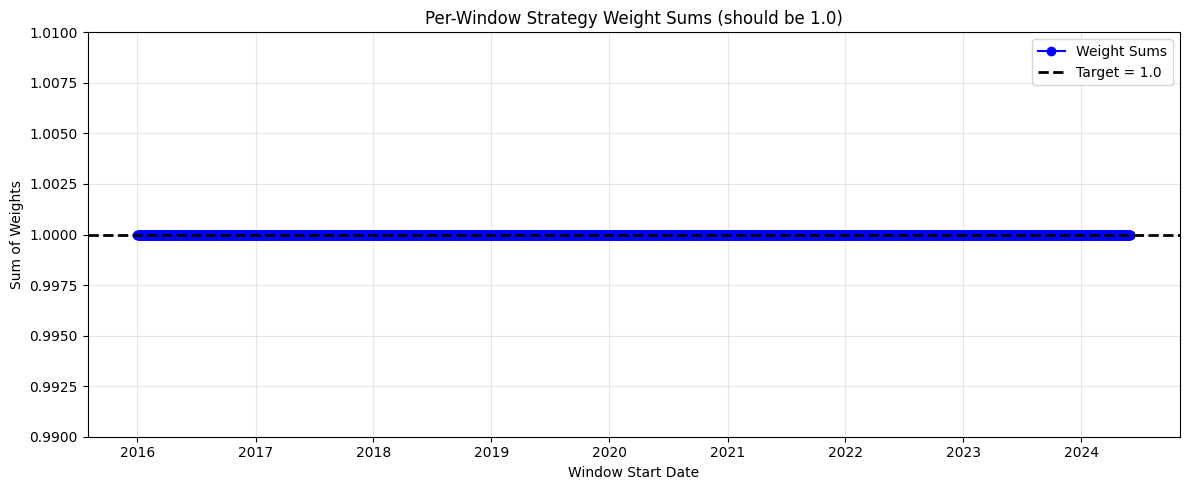


4. Running SPD backtest...

Aggregated Metrics for 200-Day MA DCA:
Dynamic Sats-per-Dollar:
  min: 1503.27
  max: 200815.48
  mean: 22840.86
  median: 8139.77

Dynamic SPD Percentiles:
  min: 13.33%
  max: 83.98%
  mean: 43.44%
  median: 43.30%

Exponential-Decay Average SPD: 1533.56
Exponential-Decay Average SPD Percentile: 65.83%

5. Plotting SPD comparison...


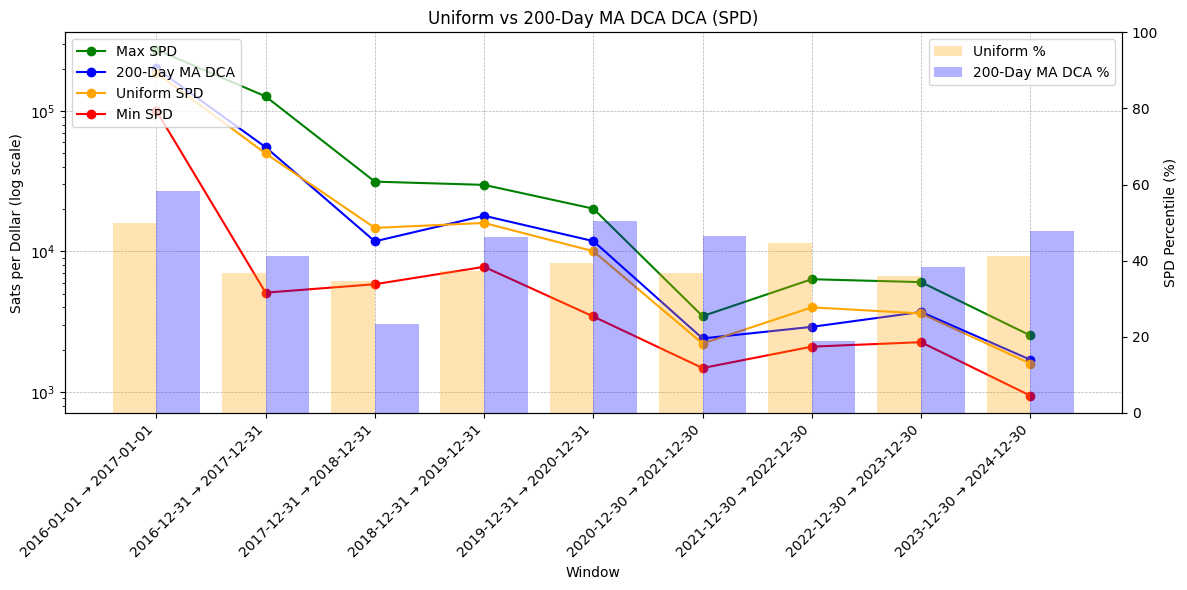


6. Running strategy validation checks...

⚠️ Windows where strategy underperformed Uniform DCA:


,Window,Dynamic Percentile,Uniform Percentile,Delta
0,2016-10-20 → 2017-10-20,40.195303,40.195303,-7.105427e-15
1,2017-07-15 → 2018-07-15,22.465870,22.523968,-5.809878e-02
2,2017-07-16 → 2018-07-16,22.101558,22.319477,-2.179192e-01
3,2017-07-17 → 2018-07-17,25.902067,26.071265,-1.691988e-01
4,2017-09-13 → 2018-09-13,31.678474,31.853681,-1.752072e-01
...,...,...,...,...
648,2022-05-02 → 2023-05-02,51.768739,54.418681,-2.649942e+00
649,2022-05-03 → 2023-05-03,52.576451,54.479423,-1.902972e+00
650,2022-05-04 → 2023-05-04,53.211021,54.537543,-1.326522e+00
651,2022-05-05 → 2023-05-05,50.739956,51.867349,-1.127394e+00



Summary: Your strategy underperformed uniform DCA in 653 out of 3075 windows (78.76% win rate)
✅ Strategy meets performance requirement (≥ 50% win rate vs. uniform DCA).

✅ Strategy is ready for submission.

7. Computing final score...

Final Model Score (50/50 weighting): 72.22%


In [126]:
print("Starting Bitcoin DCA Strategy Analysis...")

# Load and prepare data
print("Loading data...")
btc_df = load_data()
btc_df = btc_df.loc[BACKTEST_START:BACKTEST_END]
print(f"Data loaded: {len(btc_df)} records from {BACKTEST_START} to {BACKTEST_END}")

# 1) Feature plot (no weights)
print("\n1. Plotting features...")
plot_features(btc_df)

# 2) Final weights curves—computed per window
print("\n2. Plotting final weights by window...")
plot_final_weights_by_window(
    btc_df,
    compute_weights,
    window_stride=365
)

# 3) Per-window weight-sum check
print("\n3. Checking rolling window weight sums...")
plot_rolling_window_weight_sums(
    btc_df,
    compute_weights
)

# 4) Rolling-window SPD backtest
print("\n4. Running SPD backtest...")
df_spd, exp_decay_percentile = backtest_dynamic_dca(
    btc_df,
    compute_weights,
    strategy_label="200-Day MA DCA"
)

# 5) SPD comparison (subsampled by window_stride)
print("\n5. Plotting SPD comparison...")
plot_spd_comparison(
    df_spd,
    strategy_name="200-Day MA DCA",
    window_stride=365
)

# 6) Sanity checks (each window inside)
print("\n6. Running strategy validation checks...")
check_strategy_submission_ready(btc_df, compute_weights)

# win-rate = % of windows where dynamic beats uniform
win_rate = (df_spd["dynamic_percentile"] > df_spd["uniform_percentile"]).mean() * 100

# 7) Final scoring
print("\n7. Computing final score...")

score = 0.5 * win_rate + 0.5 * exp_decay_percentile
print(f"\nFinal Model Score (50/50 weighting): {score:.2f}%")